Michael Ricardo DS 2500 Project Treasure Hunter.
This project is mean to be an introduction and exploration into financial quantatative trading of U.S 10 year treasury notes.

In [666]:
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [667]:
def fetch_ticker_data(ticker):
    """
    Fetches data from the yfinance library from yahoo finance given a start date in datetime format
    until the most recent market trading day. Normalizes timezones and removes timzone for simplicity.

    Args: 
        ticker(str): Representing the offical company or instrument stock ticker, given ^ intially if an index
    Returns
        df (DataFrame): DataFrame with Instrument pricing data
    """
    
    most_recent = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
    start_date = '2014-12-01'
    
    stock_data = yf.Ticker(ticker)
    returning_data = stock_data.history(start = start_date, end= most_recent)
    
    returning_data.index = returning_data.index.tz_localize(None).normalize() #Timezone Normalization

    return returning_data

In [668]:
#Data for the IRX, Thirteen Year Treasury Bill
ticker = '^IRX'
Thirteen_Week = fetch_ticker_data(ticker)
Thirteen_Week = Thirteen_Week.drop(columns=['Open','Dividends', 'Stock Splits', 'Volume', 'High', 'Low'])
Thirteen_Week = Thirteen_Week.rename(columns={'Close': '13_week_close'})

In [669]:
#Data for the TNX, Ten Year Treasury Note 
ticker = '^TNX'
Ten_Year = fetch_ticker_data(ticker)
Ten_Year = Ten_Year.drop(columns=['Open','Dividends', 'Stock Splits', 'Volume'])
Ten_Year = Ten_Year.rename(columns={'High': '10_year_high', 'Low': '10_year_low', 'Close': '10_year_close'})

In [670]:
#Data for the BCOM, Bloomberg Commodity Index
ticker = '^BCOM'
Comm = fetch_ticker_data(ticker)
Comm['BCOM_SMA_14'] = ta.sma(Comm['Close'], length=14) 
Comm = Comm.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume', 'Close'])

In [671]:
#VIX Data, Chicago Board Options Exchange Volatility Index
ticker = '^VIX'
VIX = fetch_ticker_data(ticker)
VIX['VIX_SMA_14'] = ta.sma(VIX['Close'], length=14) 
VIX = VIX.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume', 'Close'])

Pulling external csv data, merge prep

In [672]:
#CPI data CSV, Consumer Price Index
cpi_csv = 'CPI_Data_10.csv'
cpi = pd.read_csv(cpi_csv)

In [673]:
#Cleaning CPI
cpi = cpi.rename(columns={'Close': 'CPI_close'})
cpi['Date'] = pd.to_datetime(cpi['Date'])
cpi = cpi.set_index('Date')

In [674]:
'''Fill CPI data as the monthly value present in every date time day.
    Creating new index and forward filling from the entry of 01 of each month.'''
full_date_range = pd.date_range(start='2014-12-01', end=datetime.today(), freq='D')
cpi = cpi.reindex(full_date_range)
cpi = cpi.ffill()
cpi.index.name = 'Date'

In [675]:
#One Year pulling in CSV, One Year treasury note 
one_year_csv = '1year_bond_master.csv'
One_Year = pd.read_csv(one_year_csv)

In [676]:
#Further cleaning needed for the 1 year, flipping the rows, stripping % sign to float
One_Year = One_Year.iloc[::-1] 
One_Year['Close'] = One_Year['Close'].str.rstrip('%').astype(float)
One_Year = One_Year.set_index('Date')

In [677]:
#Finding MACD and saving MACDs for evaluation 
one_year_MACD = ta.macd(One_Year["Close"], fast=12, slow=26, signal=9)
One_Year = pd.concat([One_Year, one_year_MACD], axis=1)


In [678]:
#Drop unwanted Cols
One_Year = One_Year.drop(columns=['Open', 'High', 'Low', 'Close', 'MACD_12_26_9','MACDh_12_26_9'])

Finding Short Term Spread and Yield Standerd Deviation

In [679]:
#Yield STDEV
Ten_Year['Yield_STDEV'] = ta.stdev(Ten_Year['10_year_close'], length = 14)

In [680]:
#Finding 10 year-13 week credit spread 
Ten_Year['Short_Term_Spread'] = Ten_Year['10_year_close'] - Thirteen_Week['13_week_close']

Ten_Year = Ten_Year.drop(columns=['10_year_low', '10_year_high'])

Combing existing Data frames

In [681]:

def combine(df_first, dfs):
    """
    Combining the data from multiple dataframes to df_first. Created same datetime object
    Args:
        df_main (dataframe): Main instrument set to have other cols added
        df_s (list): list of dataframes concated to df_main
    Returns:
        df_first: Concated df of df_first and dfs
    """
    for df in dfs:
        df.index = pd.to_datetime(df.index)
        df_first = pd.concat([df_first, df], axis=1)
    return df_first

In [682]:
#Merging dfs drop NA
dfs = [VIX, One_Year, cpi, Comm]
df_first = Ten_Year
final_df = combine(df_first, dfs).dropna()
final_df

,10_year_close,Yield_STDEV,Short_Term_Spread,VIX_SMA_14,MACDs_12_26_9,CPI_close,BCOM_SMA_14
Date,,,,,,,
2015-01-20,1.807,0.134184,1.799,19.477857,0.012013,234.747,103.221429
2015-01-21,1.853,0.119475,1.833,19.687143,0.008745,234.747,102.967858
2015-01-22,1.896,0.099177,1.881,19.487143,0.005734,234.747,102.772143
2015-01-23,1.817,0.082887,1.804,19.406428,0.003029,234.747,102.577143
2015-01-26,1.828,0.073557,1.823,19.092143,0.000650,234.747,102.354286
...,...,...,...,...,...,...,...
2024-11-20,4.406,0.056236,-0.004,16.714286,0.038259,315.454,97.752857
2024-11-21,4.432,0.057928,0.019,16.356429,0.039220,315.454,97.812857
2024-11-22,4.410,0.054405,-0.005,15.875000,0.040553,315.454,97.817142


In [683]:
#evaluting correlation of elements
matrix = final_df.corr()

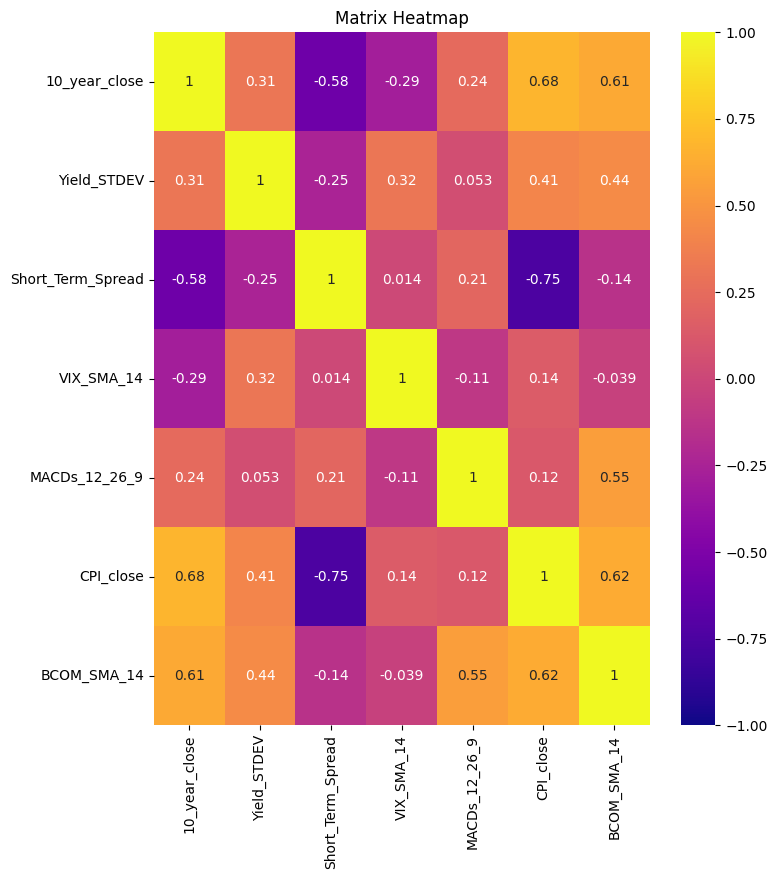

In [684]:
# Visualization: Multicollinearity with Heatmap
plt.figure(figsize=(8, 9))
sns.heatmap(matrix,annot = True, cmap="plasma", vmin=-1, vmax=1)
plt.title("Matrix Heatmap")
plt.show()

In [685]:
#Adding a year column for visualization
final_df['year'] = final_df.index.year

In [686]:
#Standerdization using X - Mean / STD formula
X_work = ['Yield_STDEV','Short_Term_Spread'	,'VIX_SMA_14','MACDs_12_26_9','CPI_close','BCOM_SMA_14']
for col in X_work:
    final_df[col] = (final_df[col] - final_df[col].mean()) / final_df[col].std()
X = final_df[['Yield_STDEV','Short_Term_Spread'	,'VIX_SMA_14','MACDs_12_26_9','CPI_close','BCOM_SMA_14']]
y = final_df['10_year_close']

Regressions:

In [687]:
def linreg_predict(X, y):
    """Predicts y vals for a given df or array using skylearn linear_regression_model
    Args:
        X (dataframe): 1 or multiple df cols pulled in as independent variables
        y (dataframe): 1 df col as dependent variables
    Returns:
        dct(dictionary): Containing ypreds, resids, rmse, r2, MAE, coef, intercept after regression
    """
    
    linear_regression_model = LinearRegression()
    linear_regression_model.fit(X, y)
    
    dct = {}

    dct["ypreds"] = linear_regression_model.predict(X)
    dct["resids"] = y - dct["ypreds"]
    dct["rmse"] = np.sqrt(((dct["ypreds"] - y) ** 2).mean())
    dct["r2"] = r2_score(y, dct["ypreds"])
    dct['MAE'] = mean_absolute_error(y, dct["ypreds"])
    dct['coef'] = linear_regression_model.coef_
    dct['intercept'] = linear_regression_model.intercept_

    return dct

In [688]:
#Doing Cross-Fold validation for multiple reg
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25, test_size = 0.3)
linear_reg_output_cross_fold = linreg_predict(X_train,y_train)
linear_reg_output_cross_fold

{'ypreds': array([3.79509413, 2.59205332, 2.50784667, ..., 3.59767814, 1.83702703,
        2.38739791]),
 'resids': Date
 2024-01-16    0.270906
 2021-11-10   -1.032053
 2019-04-08    0.011153
 2017-12-29   -0.039742
 2015-08-27    0.606228
                 ...   
 2019-09-30   -0.893293
 2016-01-27    0.920880
 2023-10-24    1.242322
 2016-04-27    0.022973
 2019-09-03   -0.921398
 Name: 10_year_close, Length: 1724, dtype: float64,
 'rmse': 0.5769704451868318,
 'r2': 0.6930714101357589,
 'MAE': 0.4836320922028509,
 'coef': array([ 0.07519389, -0.47609159, -0.301469  ,  0.07019404,  0.08138314,
         0.42946628]),
 'intercept': 2.466160774806685}

In [689]:
#Declalrations for plots
residuals = linear_reg_output_cross_fold['resids']
predictions = linear_reg_output_cross_fold['ypreds']
coefs = linear_reg_output_cross_fold['coef']

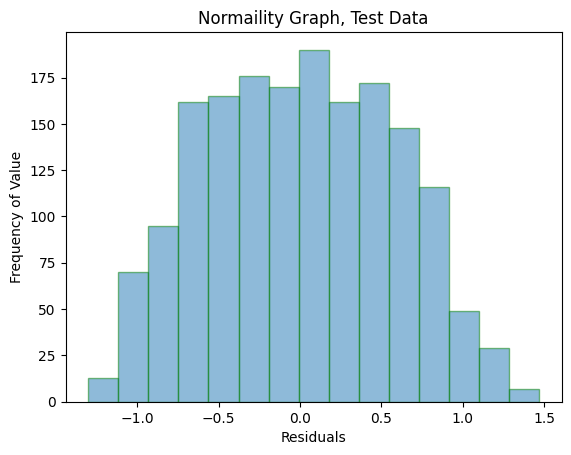

In [690]:
#Visualization: Noramility
plt.hist(residuals, bins=15, edgecolor='Green', alpha=0.5)
plt.title("Normaility Graph, Test Data")
plt.xlabel("Residuals")
plt.ylabel("Frequency of Value")
plt.show()

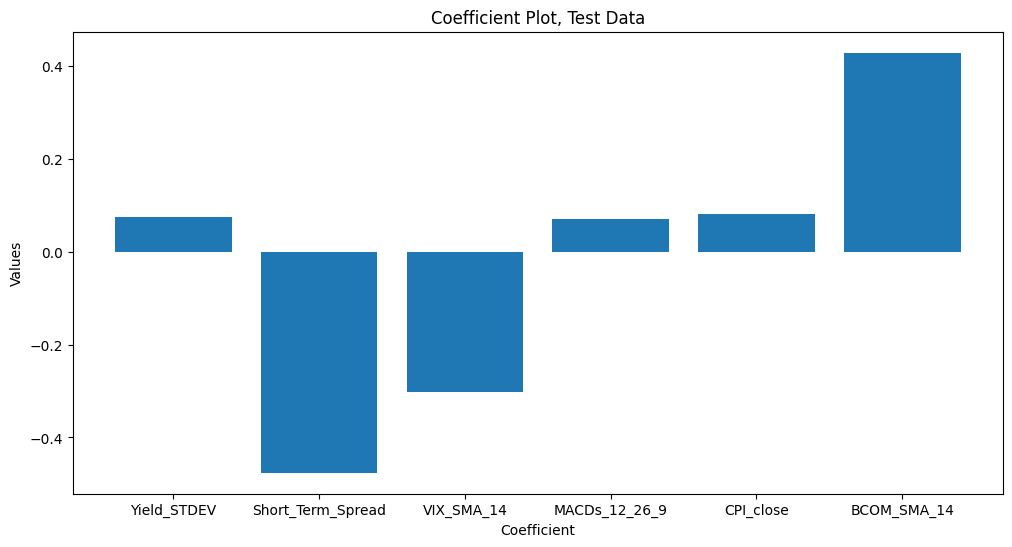

In [691]:
#Visualization: Variable importance 
plt.figure(figsize=(12, 6))
plt.bar(X_work, coefs)
plt.title('Coefficient Plot, Test Data')
plt.xlabel('Coefficient')
plt.ylabel('Values')
plt.show()

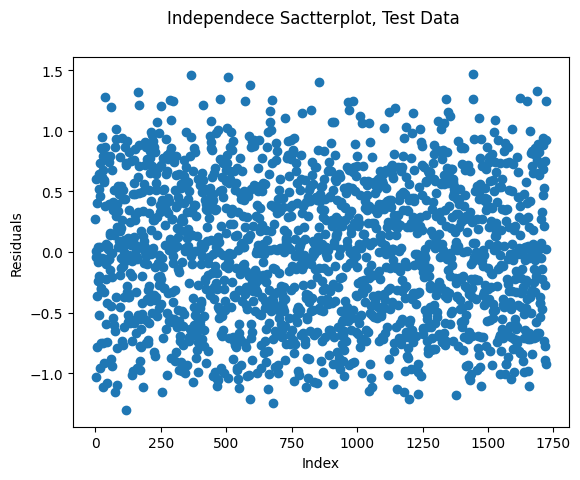

In [692]:
#Visualization: Independece graph
plt.scatter(range(len(residuals)), residuals)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.suptitle('Independece Sactterplot, Test Data')
plt.show()

Performing regression on entire dataset to analyze variabel-prediction perfromance

In [693]:
#Regressing on entire dataset for analysis upon individual forces
linear_reg_whole = linreg_predict(X,y)
linear_reg_whole

{'ypreds': array([2.30174917, 2.23693398, 2.17511584, ..., 3.26506132, 3.35059068,
        3.34279645]),
 'resids': Date
 2015-01-20   -0.494749
 2015-01-21   -0.383934
 2015-01-22   -0.279116
 2015-01-23   -0.355495
 2015-01-26   -0.322259
                 ...   
 2024-11-20    1.179657
 2024-11-21    1.193863
 2024-11-22    1.144939
 2024-11-25    0.914409
 2024-11-26    0.959204
 Name: 10_year_close, Length: 2464, dtype: float64,
 'rmse': 0.5757788785152916,
 'r2': 0.6960353213935087,
 'MAE': 0.48327239582533305,
 'coef': array([ 0.07799037, -0.47021395, -0.30755095,  0.06449137,  0.09012123,
         0.43185203]),
 'intercept': 2.461628245818731}

In [694]:
#Declalrations for plots
resids = linear_reg_whole['resids']
ypreds = linear_reg_whole['ypreds']
coefs = linear_reg_whole['coef']

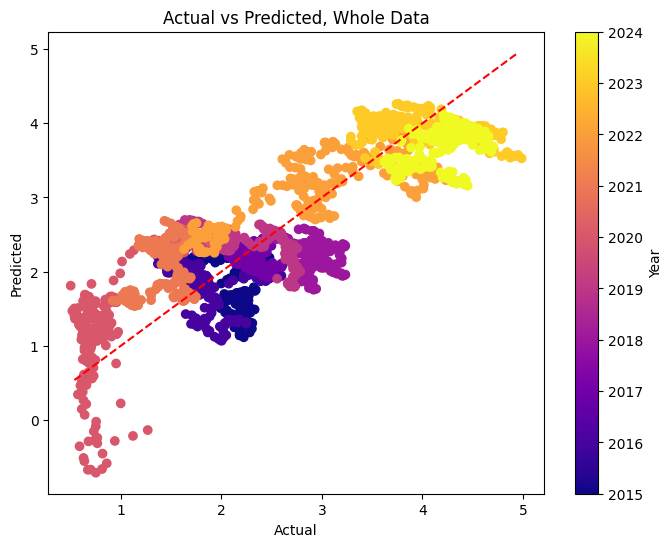

In [695]:
#Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plot = plt.scatter(y, ypreds, c=final_df['year'],cmap='plasma')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.colorbar(plot, label='Year')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted, Whole Data')
plt.show()

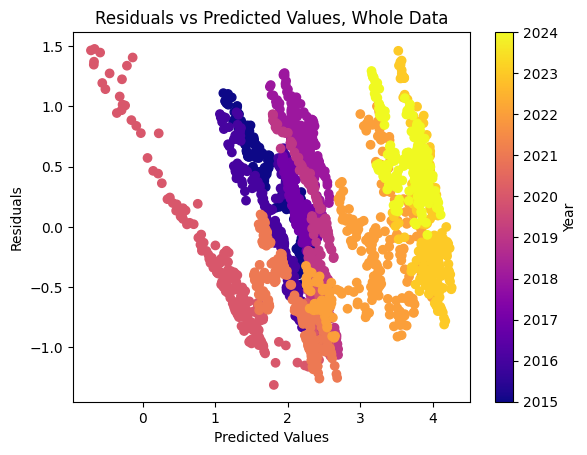

In [696]:
#Visualization: Residual vs Predicted plot
plot = plt.scatter(ypreds, resids, c=final_df['year'],cmap='plasma')
plt.colorbar(plot, label='Year')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values, Whole Data")
plt.show()

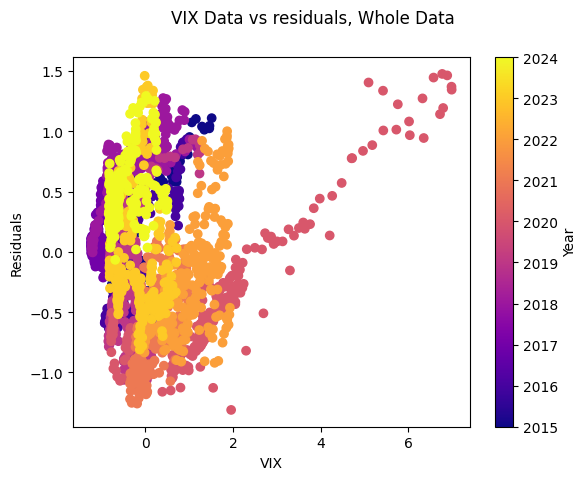

In [697]:
#Visualization: VIX Data vs resids 
plot = plt.scatter(final_df['VIX_SMA_14'], resids, c=final_df['year'], cmap='plasma')
plt.colorbar(plot, label='Year')
plt.xlabel('VIX')
plt.ylabel('Residuals')
plt.suptitle('VIX Data vs residuals, Whole Data')
plt.show()

/tmp/ipykernel_1730/913986758.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


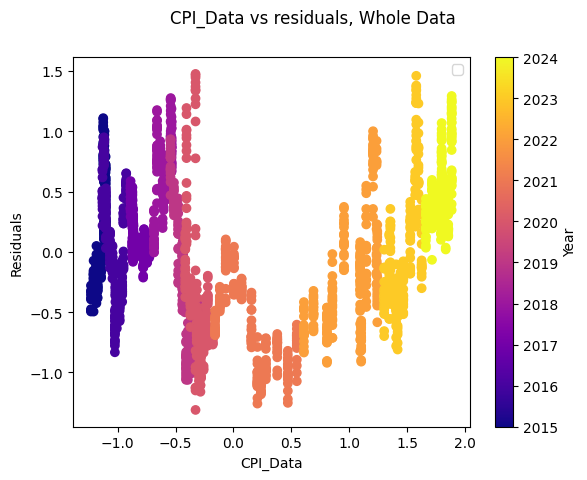

In [698]:
#Visualization: CPI vs resids 
plot = plt.scatter(final_df['CPI_close'], resids, c=final_df['year'], cmap='plasma')
plt.colorbar(plot, label='Year')
plt.xlabel('CPI_Data')
plt.ylabel('Residuals')
plt.suptitle('CPI_Data vs residuals, Whole Data')
plt.legend()
plt.show()

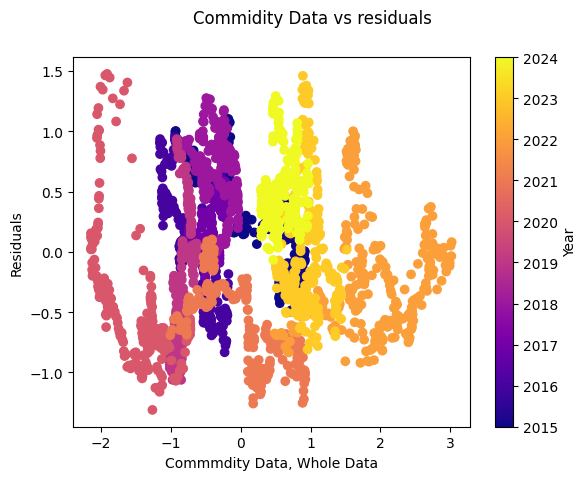

In [699]:
#Visualization: Commodities vs resids 
plot = plt.scatter(final_df['BCOM_SMA_14'], resids, c=final_df['year'], cmap='plasma')
plt.colorbar(plot, label='Year')
plt.xlabel('Commmdity Data, Whole Data')
plt.ylabel('Residuals')
plt.suptitle('Commidity Data vs residuals')
plt.show()

Polynomial regression 

In [700]:
from sklearn.preprocessing import PolynomialFeatures
#Performing Polynomial Regression Intro 
X_cpi = final_df['CPI_close'].to_numpy().reshape(-1, 1)
X_BCOM = final_df['BCOM_SMA_14'].to_numpy().reshape(-1, 1)
poly_fit = PolynomialFeatures(degree = 4, include_bias = True)


In [701]:
#Training data for cpi poly
X_poly_cpi = poly_fit.fit_transform(X_cpi)
X_train, X_test, y_train, y_test = train_test_split(X_poly_cpi, y, random_state=25, test_size = 0.3)

In [702]:
#Regressing on testing set for analysis
poly_reg_test = linreg_predict(X_train,y_train)
poly_reg_test

{'ypreds': array([4.32998381, 1.40252175, 1.95588362, ..., 4.28839255, 2.16692017,
        1.87295839]),
 'resids': Date
 2024-01-16   -0.263984
 2021-11-10    0.157478
 2019-04-08    0.563116
 2017-12-29    0.034263
 2015-08-27    0.104849
                 ...   
 2019-09-30   -0.197958
 2016-01-27   -0.015154
 2023-10-24    0.551608
 2016-04-27   -0.306920
 2019-09-03   -0.406958
 Name: 10_year_close, Length: 1724, dtype: float64,
 'rmse': 0.46759455077912876,
 'r2': 0.7984099502199244,
 'MAE': 0.3581912696640019,
 'coef': array([ 0.        , -0.89234653,  2.07232453,  1.11847699, -0.83026412]),
 'intercept': 1.2889543615443555}

In [703]:
#Doing polynomial on the whole dataset for visualization
poly_reg_cpi = linreg_predict(X_poly_cpi,y)
ypreds_cpi = poly_reg_cpi['ypreds']
resids_cpi = poly_reg_cpi['resids']
poly_reg_cpi

{'ypreds': array([1.5384009 , 1.5384009 , 1.5384009 , ..., 3.97361959, 3.97361959,
        3.97361959]),
 'resids': Date
 2015-01-20    0.268599
 2015-01-21    0.314599
 2015-01-22    0.357599
 2015-01-23    0.278599
 2015-01-26    0.289599
                 ...   
 2024-11-20    0.432381
 2024-11-21    0.458381
 2024-11-22    0.436380
 2024-11-25    0.291380
 2024-11-26    0.328380
 Name: 10_year_close, Length: 2464, dtype: float64,
 'rmse': 0.4699071401921588,
 'r2': 0.797541623542209,
 'MAE': 0.35964918891558645,
 'coef': array([ 0.        , -0.88540351,  2.0903971 ,  1.11642474, -0.83500362]),
 'intercept': 1.2770087212533396}

In [704]:
#Doing polynomial on the whole dataset for BCOM just for curiosity, it failed :(
X_poly_BCOM = poly_fit.fit_transform(X_BCOM)
poly_reg_bcom = linreg_predict(X_poly_BCOM,y)
resids_bcom = poly_reg_bcom['resids']
ypreds_bcom = poly_reg_bcom['ypreds']
poly_reg_bcom

{'ypreds': array([3.25161461, 3.24363749, 3.23734578, ..., 3.04057097, 3.03749817,
        3.03830091]),
 'resids': Date
 2015-01-20   -1.444615
 2015-01-21   -1.390637
 2015-01-22   -1.341346
 2015-01-23   -1.413961
 2015-01-26   -1.395523
                 ...   
 2024-11-20    1.368435
 2024-11-21    1.391629
 2024-11-22    1.369429
 2024-11-25    1.227502
 2024-11-26    1.263699
 Name: 10_year_close, Length: 2464, dtype: float64,
 'rmse': 0.7637566842871742,
 'r2': 0.4651626726833724,
 'MAE': 0.6058384974428517,
 'coef': array([ 0.        ,  0.88648091, -0.20648581, -0.05093638,  0.00592009]),
 'intercept': 2.676641742375466}

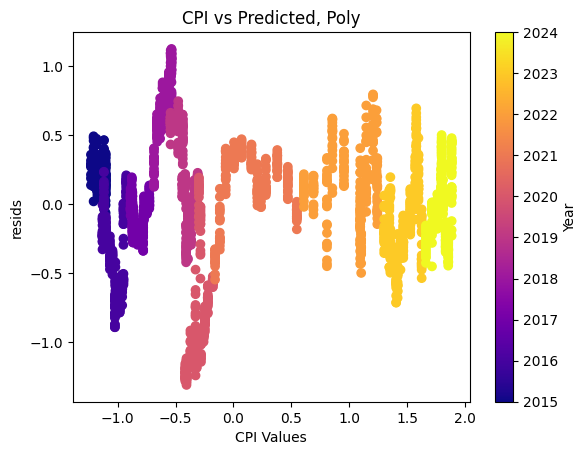

In [705]:
# Visualization: CPI vs Resids Polynomial 
plot = plt.scatter(final_df['CPI_close'], resids_cpi, c=final_df['year'], cmap='plasma')
plt.colorbar(plot, label='Year')
plt.xlabel('CPI Values')
plt.ylabel('resids')
plt.title('CPI vs Predicted, Poly')
plt.show()

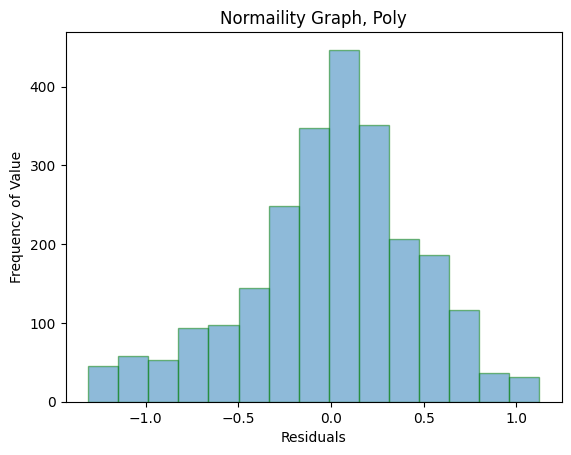

In [706]:
#Visualization: Normaility for poly
plt.hist(resids_cpi, bins=15, edgecolor='Green', alpha=0.5)
plt.title("Normaility Graph, Poly")
plt.xlabel("Residuals")
plt.ylabel("Frequency of Value")
plt.show()


Links:

#Source for MACD
https://tradingstrategy.ai/docs/api/technical-analysis/momentum/help/pandas_ta.momentum.macd.html

#Data source for One-Year Treasury
https://www.marketwatch.com/investing/bond/tmubmusd01y/download-data?countrycode=bx&mod=mw_quote_tab 

#Yfinance
https://pypi.org/project/yfinance/

#CPI
https://fred.stlouisfed.org/series/CPIAUCSL